In [1]:
# python
from tqdm.notebook import tqdm
import sys
import os
import importlib
# columnar analysis
import awkward as ak
import mplhep as hep
import numpy as np
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
# local
sys.path.insert(1, os.path.join(sys.path[0], '../../..')) # fixme: there must be a better way to handle this...
from sidm.tools import ffschema, sidm_processor, utilities
# always reload local modules to pick up changes during development
importlib.reload(sidm_processor)
importlib.reload(utilities)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline
import vector
import numpy as np
from scipy import stats
from scipy.stats import expon
from scipy.optimize import differential_evolution

In [2]:
events = {}

evt_500_5p0_0p08 = NanoEventsFactory.from_root(
    "/home/cms-jovyan/local_data/Heavy_ion/SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-0p08_v1_part-41.root",
    schemaclass=NanoAODSchema,
).events()

evt_500_5p0_0p8 = NanoEventsFactory.from_root(
    "/home/cms-jovyan/local_data/Heavy_ion/SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-0p8_v1_part-39.root",
    schemaclass=NanoAODSchema,
).events()

evt_500_5p0_0p08_cutdecayfalse = NanoEventsFactory.from_root(
    "/home/cms-jovyan/local_data/Heavy_ion/SIDM_CutDecayFalse_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-0p08_v2_part-0.root",
    schemaclass=NanoAODSchema,
).events()

# evt_500_5p0_8p0 = NanoEventsFactory.from_root(
#     "/home/cms-jovyan/local_data/Heavy_ion/SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-8p0_v1_part-1.root",
#     schemaclass=NanoAODSchema,
# ).events()

# evt_500_5p0_40p0 = NanoEventsFactory.from_root(
#     "/home/cms-jovyan/local_data/Epsilon/Drop/SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-40p0.root",
#     schemaclass=NanoAODSchema,
# ).events()

# evt_500_5p0_80p0 = NanoEventsFactory.from_root(
#     "/home/cms-jovyan/local_data/Heavy_ion/SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-80p0_v1_part-23.root",
#     schemaclass=NanoAODSchema,
# ).events()

In [3]:
events['4mu_500GeV_5p0GeV_0p08mm'] = evt_500_5p0_0p08
events['4mu_500GeV_5p0GeV_0p8mm'] = evt_500_5p0_0p8
events['4mu_500GeV_5p0GeV_0p08mm_false'] = evt_500_5p0_0p08_cutdecayfalse

In [4]:
events

{'4mu_500GeV_5p0GeV_0p08mm': <NanoEventsArray [<event 1:1:1>, ... <event 1:1:199>] type='712 * event'>,
 '4mu_500GeV_5p0GeV_0p8mm': <NanoEventsArray [<event 1:1:4>, ... <event 1:1:198>] type='477 * event'>,
 '4mu_500GeV_5p0GeV_0p08mm_false': <NanoEventsArray [<event 1:1:2>, ... <event 1:1:20>] type='147 * event'>}

In [5]:
def extract_values(events, sample):
    
    genpart = events["{0}".format(sample)].GenPart
    dps = genpart[abs(genpart.pdgId) == 32]
    mask = ak.all(abs(dps.children.pdgId) == 13, axis=-1)
    dps_tomu = dps[mask]
    
    dps_tomu_vec = vector.zip({
        "pt": dps_tomu.pt,
        "eta": dps_tomu.eta,
        "phi": dps_tomu.phi,
        "mass": dps_tomu.mass})
    
    lxyz = ak.flatten(((dps_tomu.children.vx - dps_tomu.vx)**2 + (dps_tomu.children.vy - dps_tomu.vy)**2 + (dps_tomu.children.vz - dps_tomu.vz)**2)**0.5) 
    gamma = ak.flatten(dps_tomu_vec.gamma)
    beta = ak.flatten(dps_tomu_vec.beta)
    
    print("DP mass : {0}".format(dps_tomu.mass))
    
    return lxyz, gamma, beta

In [6]:
def plotting(events, sample, ranges, i, co):
    
    plt_range = (0, ranges)
    
    lxyz, gamma, beta = extract_values(events, sample)
    
    lxyz_gb = lxyz/(gamma * beta)
    P = stats.expon.fit(lxyz_gb)
    
    ax[i].hist(ak.flatten(lxyz_gb), range=plt_range, linewidth=3, bins=100, histtype='step', label=sample, density=True, color=co)
    ax[i].plot(np.linspace(*plt_range,100), stats.expon.pdf(np.linspace(*plt_range,100), *P), label=fr"exp[ -(x - {P[0]:.3e}) / {P[1]:.3e} ] / {P[1]:.3e}", color='black')
    ax[i].set_yscale("log")
    ax[i].legend(fontsize=18, loc='upper right')
    ax[i].set_xlabel(r"$V_{xyz}$/$\beta\gamma$")

In [7]:
pip install zfit

  Obtaining dependency information for zfit from https://files.pythonhosted.org/packages/da/b5/8f9bfaef73a1407f591ff9194e4f5fc5f9e82c0d824648462d9b86d57a3f/zfit-0.22.0-py2.py3-none-any.whl.metadata
  Using cached zfit-0.22.0-py2.py3-none-any.whl.metadata (44 kB)
  Obtaining dependency information for colored from https://files.pythonhosted.org/packages/75/d1/548f697f88872321525e294f8863efbdd1c313964b7f94e49ab0dc4f2895/colored-2.2.4-py3-none-any.whl.metadata
  Using cached colored-2.2.4-py3-none-any.whl.metadata (3.6 kB)
  Obtaining dependency information for colorlog from https://files.pythonhosted.org/packages/f3/18/3e867ab37a24fdf073c1617b9c7830e06ec270b1ea4694a624038fc40a03/colorlog-6.8.2-py3-none-any.whl.metadata
  Using cached colorlog-6.8.2-py3-none-any.whl.metadata (10 kB)
  Obtaining dependency information for deprecated from https://files.pythonhosted.org/packages/20/8d/778b7d51b981a96554f29136cd59ca7880bf58094338085bcf2a979a0e6a/Deprecated-1.2.14-py2.py3-none-any.whl.metadata

In [8]:
import zfit

/opt/conda/lib/python3.9/site-packages/zfit/__init__.py:60: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(
2024-10-29 13:17:49.144581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 13:17:49.160715: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 13:17:49.160730: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
def zfit_plotting(events, sample, ranges, i, co):
    
    plt_range = (0, ranges)
    rho, gamma, beta = extract_values(events, sample)
    
    lxyz_gb = ak.to_numpy(ak.flatten(rho/(gamma * beta)))
    obs_space = zfit.Space("lxyz_gb", limits=plt_range)
    data = zfit.Data.from_numpy(obs=obs_space, array=lxyz_gb)
    
    lambda_param = zfit.Parameter("lambda", 1)
    exp_model = zfit.pdf.Exponential(lambda_param, obs=obs_space)

    nll = zfit.loss.UnbinnedNLL(model=exp_model, data=data)

    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(nll)
    param_val = result.params[lambda_param]['value']
    
    offset = 0
    scale_param = 1 / param_val

    ax[i].hist(lxyz_gb, range=plt_range, linewidth=3, bins=100, histtype='step', label=sample, density=True, color=co)

    x_vals = np.linspace(*plt_range, 100)
    pdf_vals = exp_model.pdf(x_vals, norm_range=obs_space)
    ax[i].plot(x_vals, pdf_vals, label=fr"exp[ -(x - {offset:.3e}) / {scale_param:.3e} ] / {scale_param:.3e}", color='black')
    ax[i].set_yscale("log")
    ax[i].legend(fontsize=18, loc='upper right')
    ax[i].set_xlabel(r"$L_{xyz}$/$\beta\gamma$")

DP mass : [[5.02, 5], [5.03, 5], [5, 4.98], [5, 5], ... 5.02, 5], [5, 5], [5.03, 5], [4.98, 5]]
DP mass : [[5, 5.02], [4.98, 5], [5, 5], [5, 5], ... [5, 5], [5.02, 5], [5, 5.02], [4.98, 5]]
DP mass : [[5.02, 5.02], [4.98, 5], [4.98, 5.09], [4.97, 5, ... 5], [5, 5], [5, 5], [5, 5]]


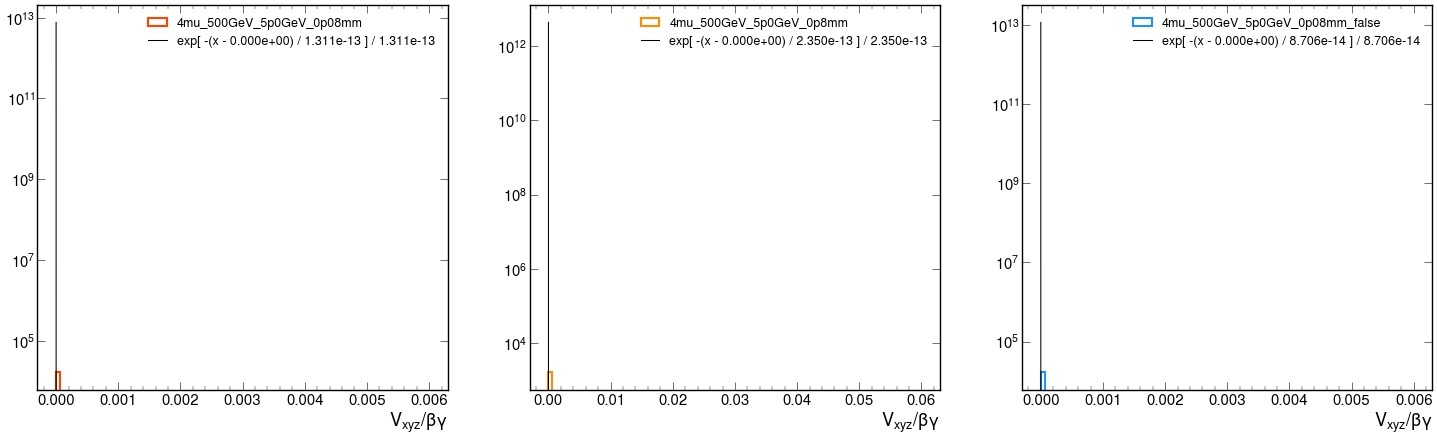

In [16]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(1, 3, figsize=(36, 10)) 

plotting(events, "4mu_500GeV_5p0GeV_0p08mm", 0.006,0, "orangered")
plotting(events, "4mu_500GeV_5p0GeV_0p8mm", 0.06,1, "darkorange")
plotting(events, "4mu_500GeV_5p0GeV_0p08mm_false", 0.006,2, "dodgerblue")

DP mass : [[5.02, 5], [5.03, 5], [5, 4.98], [5, 5], ... 5.02, 5], [5, 5], [5.03, 5], [4.98, 5]]
DP mass : [[5, 5.02], [4.98, 5], [5, 5], [5, 5], ... [5, 5], [5.02, 5], [5, 5.02], [4.98, 5]]
DP mass : [[5.02, 5.02], [4.98, 5], [4.98, 5.09], [4.97, 5, ... 5], [5, 5], [5, 5], [5, 5]]


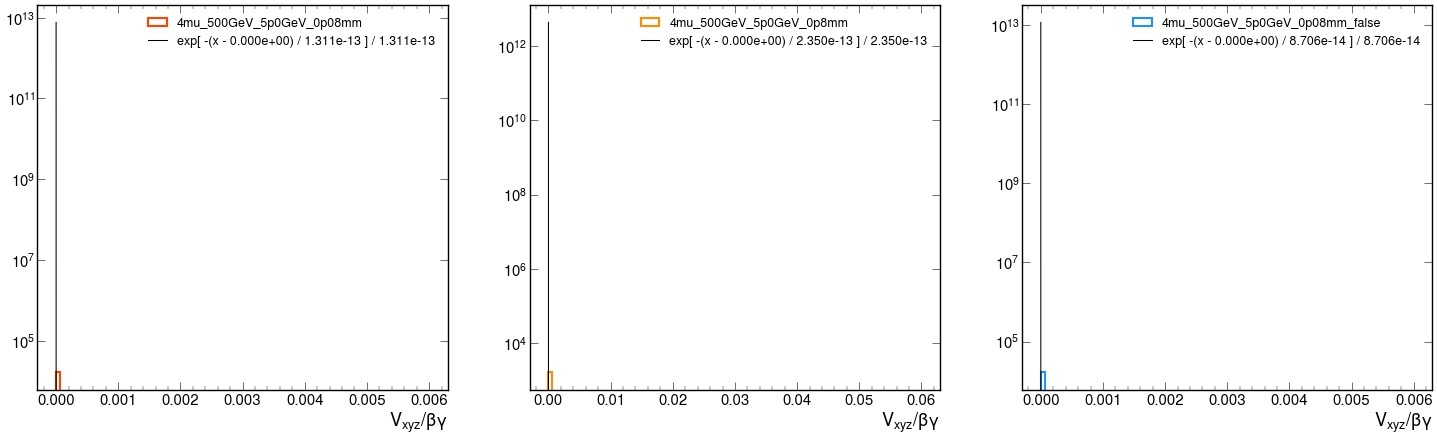

In [17]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(1, 3, figsize=(36, 10)) 

plotting(events, "4mu_500GeV_5p0GeV_0p08mm", 0.006,0, "orangered")
plotting(events, "4mu_500GeV_5p0GeV_0p8mm", 0.06,1, "darkorange")
plotting(events, "4mu_500GeV_5p0GeV_0p08mm_false", 0.006,2, "dodgerblue")

In [18]:
def plotting_lxy(events, sample, ranges, i, co):
    
    plt_range = (0, ranges)
    
    lxyz, gamma, beta = extract_values(events, sample)
    
    lxyz_gb = lxyz
    P = stats.expon.fit(lxyz_gb)
    
    ax[i].hist(ak.flatten(lxyz_gb), range=plt_range, linewidth=3, bins=100, histtype='step', label=sample, density=True, color=co)
    ax[i].plot(np.linspace(*plt_range,100), stats.expon.pdf(np.linspace(*plt_range,100), *P), label=fr"exp[ -(x - {P[0]:.3e}) / {P[1]:.3e} ] / {P[1]:.3e}", color='black')
    ax[i].set_yscale("log")
    ax[i].legend(fontsize=18, loc='upper right')
    ax[i].set_xlabel(r"$V_{xyz}$")

DP mass : [[5.02, 5], [5.03, 5], [5, 4.98], [5, 5], ... 5.02, 5], [5, 5], [5.03, 5], [4.98, 5]]
DP mass : [[5, 5.02], [4.98, 5], [5, 5], [5, 5], ... [5, 5], [5.02, 5], [5, 5.02], [4.98, 5]]
DP mass : [[5.02, 5.02], [4.98, 5], [4.98, 5.09], [4.97, 5, ... 5], [5, 5], [5, 5], [5, 5]]


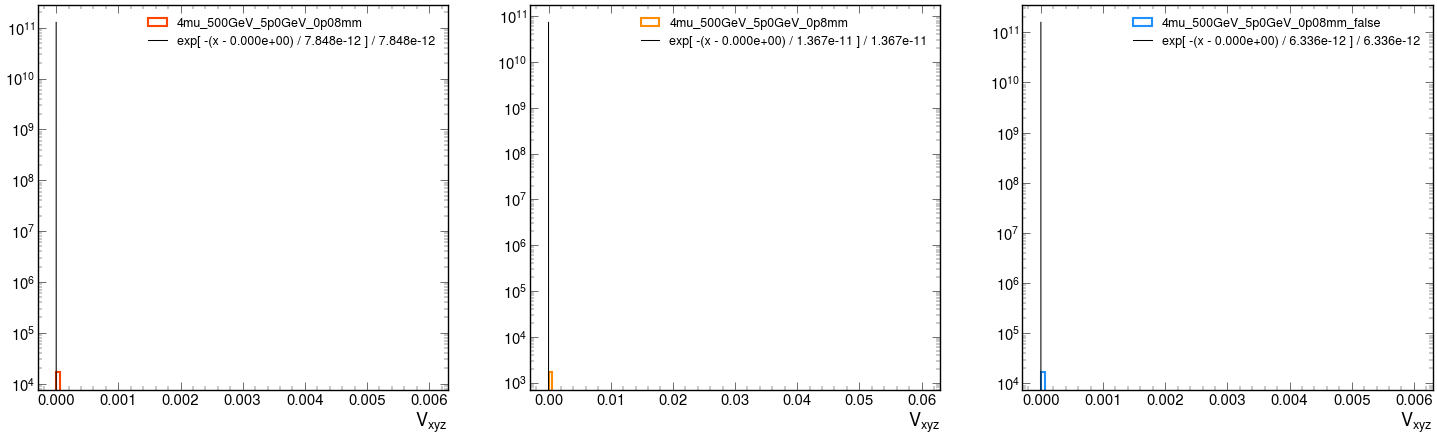

In [20]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(1, 3, figsize=(36, 10)) 

plotting_lxy(events, "4mu_500GeV_5p0GeV_0p08mm", 0.006,0, "orangered")
plotting_lxy(events, "4mu_500GeV_5p0GeV_0p8mm", 0.06,1, "darkorange")
plotting_lxy(events, "4mu_500GeV_5p0GeV_0p08mm_false", 0.006,2, "dodgerblue")

DP mass : [[5.02, 5], [5.03, 5], [5, 4.98], [5, 5], ... 5.02, 5], [5, 5], [5.03, 5], [4.98, 5]]
DP mass : [[5, 5.02], [4.98, 5], [5, 5], [5, 5], ... [5, 5], [5.02, 5], [5, 5.02], [4.98, 5]]
DP mass : [[5.02, 5.02], [4.98, 5], [4.98, 5.09], [4.97, 5, ... 5], [5, 5], [5, 5], [5, 5]]


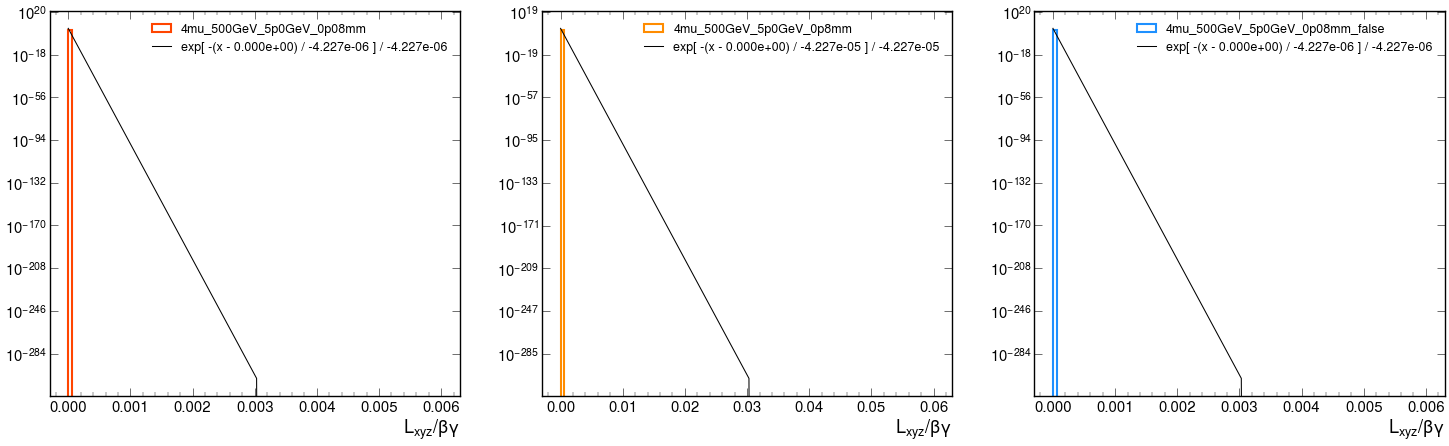

In [21]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(1, 3, figsize=(36, 10)) 

zfit_plotting(events, "4mu_500GeV_5p0GeV_0p08mm", 0.006,0, "orangered")
zfit_plotting(events, "4mu_500GeV_5p0GeV_0p8mm", 0.06,1, "darkorange")
zfit_plotting(events, "4mu_500GeV_5p0GeV_0p08mm_false", 0.006,2, "dodgerblue")

In [22]:
def zfit_plotting_lxy(events, sample, ranges, i, co):
    
    plt_range = (0, ranges)
    rho, gamma, beta = extract_values(events, sample)
    
    lxyz_gb = ak.to_numpy(ak.flatten(rho))
    obs_space = zfit.Space("lxyz_gb", limits=plt_range)
    data = zfit.Data.from_numpy(obs=obs_space, array=lxyz_gb)
    
    lambda_param = zfit.Parameter("lambda", 1)
    exp_model = zfit.pdf.Exponential(lambda_param, obs=obs_space)

    nll = zfit.loss.UnbinnedNLL(model=exp_model, data=data)

    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(nll)
    param_val = result.params[lambda_param]['value']
    
    offset = 0
    scale_param = 1 / param_val

    ax[i].hist(lxyz_gb, range=plt_range, linewidth=3, bins=100, histtype='step', label=sample, density=True, color=co)

    x_vals = np.linspace(*plt_range, 100)
    pdf_vals = exp_model.pdf(x_vals, norm_range=obs_space)
    ax[i].plot(x_vals, pdf_vals, label=fr"exp[ -(x - {offset:.3e}) / {scale_param:.3e} ] / {scale_param:.3e}", color='black')
    ax[i].set_yscale("log")
    ax[i].legend(fontsize=18, loc='upper right')
    ax[i].set_xlabel(r"$L_{xyz}$")

DP mass : [[5.02, 5], [5.03, 5], [5, 4.98], [5, 5], ... 5.02, 5], [5, 5], [5.03, 5], [4.98, 5]]
DP mass : [[5, 5.02], [4.98, 5], [5, 5], [5, 5], ... [5, 5], [5.02, 5], [5, 5.02], [4.98, 5]]
DP mass : [[5.02, 5.02], [4.98, 5], [4.98, 5.09], [4.97, 5, ... 5], [5, 5], [5, 5], [5, 5]]


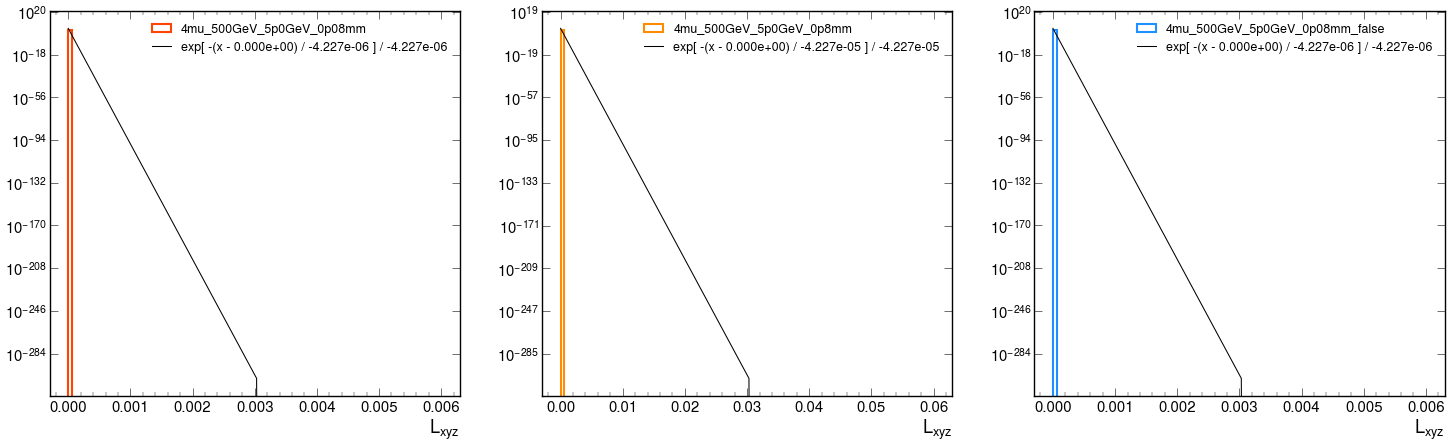

In [23]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(1, 3, figsize=(36, 10)) 

zfit_plotting_lxy(events, "4mu_500GeV_5p0GeV_0p08mm", 0.006,0, "orangered")
zfit_plotting_lxy(events, "4mu_500GeV_5p0GeV_0p8mm", 0.06,1, "darkorange")
zfit_plotting_lxy(events, "4mu_500GeV_5p0GeV_0p08mm_false", 0.006,2, "dodgerblue")